# 1. Set up environment

In [ ]:
! pip install --quiet underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 54.0 MB/s eta 0:00:00


In [ ]:
# see data preprocessing steps at link:
# https://colab.research.google.com/drive/1AuvWD-Lo6UIjyb_fmjxGB1zLZWZQ7GFf?ouid=115125045212634117084&usp=drive_link

from data_preprocessing import *
import seaborn as sns
import numpy as np
import pandas as pd
import re
import string
from underthesea import word_tokenize, text_normalize
from gensim.models import word2vec
import matplotlib.pyplot as plt

with open("/content/drive/MyDrive/THESIS DSEB62: Product review analysis/word2vecvn/vietnamese-stopwords.txt") as f: # stopwords from spacy
    STOPWORDS = f.readlines()
    STOPWORDS = [remove_all_tag(i) for i in STOPWORDS]

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/THESIS DSEB62: Product review analysis/Joined Data/final_data.xlsx")

def relabel(label):
    if label != 0:
        return 1
    else:
        return 0

data = data.fillna(0)
data["Quality"] =  data["Quality"].apply(lambda x: relabel(x))
data["Serve"] =  data["Serve"].apply(lambda x: relabel(x))
data["Quality"] =  data["Quality"].apply(lambda x: relabel(x))
data["Pack"] =  data["Pack"].apply(lambda x: relabel(x))
data["Shipping"] =  data["Shipping"].apply(lambda x: relabel(x))

df = data.copy()
df["comment"] = df["comment"].apply(lambda x: cleaning(x))


# 2. EDA

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generate_wordcloud_by_label(label):
    """A function to plot the wordcloud from the reviews in the datasets
    Parameters
    ----------
    label : str
    the label group in which the reviews is sampled from
    """
    wc = WordCloud(background_color="white", stopwords=STOPWORDS).generate(str(df[df[label] == 1]["comment"].apply(lambda x: word_tokenize(x, format = "text")).values))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Wordcloud for reviews about {label}")
    plt.show()

Text(0.5, 1.0, 'Distribution of review length by syllables')

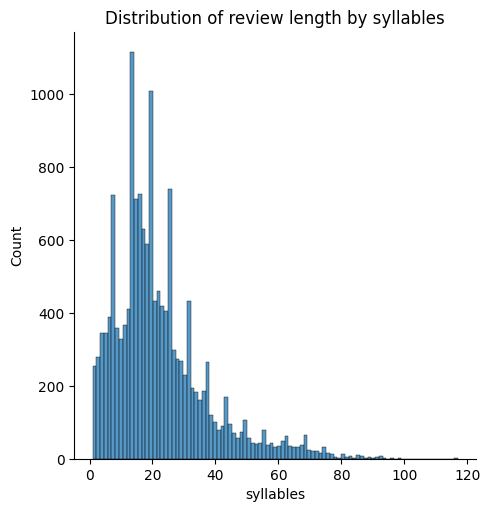

In [ ]:
df["syllables"] = df["comment"].str.split().agg([len])

sns.displot(df["syllables"])
plt.title("Distribution of review length by syllables")

In [ ]:
df["Serve"].value_counts()

0    12385
1     3047
Name: Serve, dtype: int64

In [ ]:
df["Quality"].value_counts()

1    12522
0     2910
Name: Quality, dtype: int64

In [ ]:
df["Shipping"].value_counts()

0    8924
1    6508
Name: Shipping, dtype: int64

In [ ]:
df["Pack"].value_counts()

0    12488
1     2944
Name: Pack, dtype: int64

In [ ]:
length = df["comment"].apply(lambda x : len(x))
print("Comment Length Stat")
print(length.describe())

Comment Length Stat
count    15432.000000
mean       102.506026
std         70.022444
min          2.000000
25%         59.000000
50%         86.000000
75%        130.000000
max        767.000000
Name: comment, dtype: float64


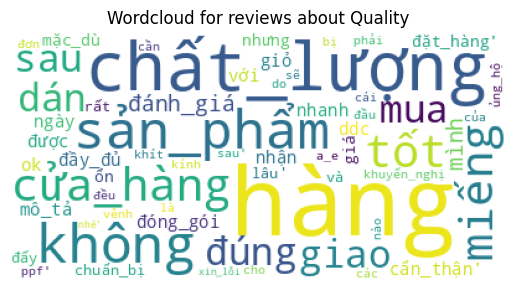

In [ ]:
generate_wordcloud_by_label("Quality")

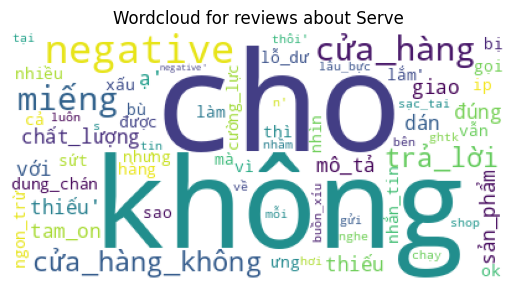

In [ ]:
generate_wordcloud_by_label("Serve")

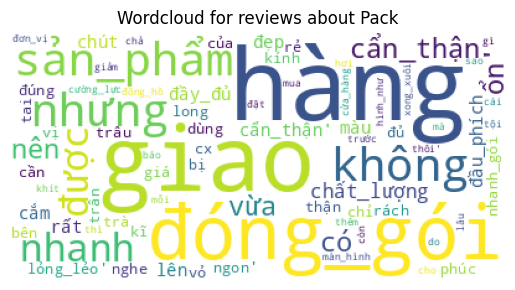

In [ ]:
generate_wordcloud_by_label("Pack")

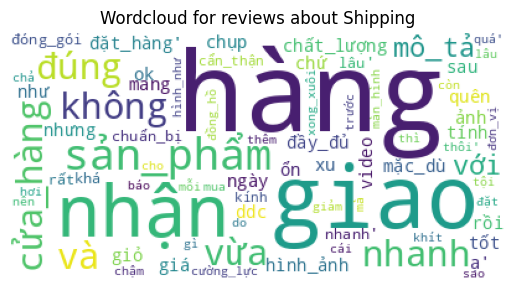

In [ ]:
generate_wordcloud_by_label("Shipping")

# 3. Baseline model
(Bag-of-words + SVM)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

X_train, X_test, y_train, y_test = train_test_split(df["comment"], df[["Quality", "Pack", "Serve", "Shipping"]], test_size= 0.2, random_state= 60)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

def displayConfusionMatrix(y_true, y_pred):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred, #np.argmax(y_pred, axis=1),
        display_labels=["0","1"],
        cmap=plt.cm.Blues
    )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + " Dataset -- F1 Score: " + str(f1_score.round(2)))


text_clf = Pipeline([
('vect', CountVectorizer(ngram_range=(1, 5), tokenizer=word_tokenize, stop_words=STOPWORDS,max_df=0.5, min_df=4)),
# ngram_range: context window for each feature
# max_df = 0.50 means "ignore terms that appear in more than 50% of the reviews"
# min_df = 4 means "ignore terms that appear in less than 4 reviews"
('clf', SGDClassifier(loss='hinge', penalty='l2',
alpha=1e-3, random_state=42,
max_iter=5, tol=None)), # loss = "hinge" equivalent to SVM
])

## 3.1 Model Quality

In [ ]:
model_quality_sgd = text_clf
model_quality_sgd.fit(X_train, y_train["Quality"])


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'ai', 'alô', 'amen', 'anh', 'ba', 'ba ba', 'bao', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bay', 'biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết đâu', 'buổi', 'bà', 'bài', 'bác', 'bán', 'bán dạ', 'bây', 'bây bẩy', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bông', 'bước', 'bạn', 'bản', 'bản thân', 'bất', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất thình', 'bất tử', 'bất ý', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâu nay', 'bấy nay', 'bấy nhiêu', 'bập', 'bập bõm', 'bắt đầu', 'bằng', 'bển', 'bệt', 'bị', 

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, min_df=4, ngram_range=(1, 5),
                                 stop_words=['a lô ', 'a ha ', 'ai ', 'ai ai ',
                                             'ai nấy ', 'ai đó ', 'alô ',
                                             'amen ', 'anh ', 'anh ấy ', 'ba ',
                                             'ba ba ', 'ba bản ', 'ba cùng ',
                                             'ba họ ', 'ba ngày ', 'ba ngôi ',
                                             'ba tăng ', 'bao giờ ', 'bao lâu ',
                                             'bao nhiêu ', 'bao nả ',
                                             'bay biến ', 'biết ', 'biết bao ',
                                             'biết bao nhiêu ', 'biết chắc ',
                                             'biết chừng nào ', 'biết mình ',
                                             'biết mấy ', ...],
                                 tokenizer=<function word_tokenize at 0x7df2bf9d3e20>)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
print(classification_report(y_test["Quality"], model_quality_sgd.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.42      0.50       586
           1       0.87      0.94      0.91      2501

    accuracy                           0.84      3087
   macro avg       0.75      0.68      0.70      3087
weighted avg       0.82      0.84      0.83      3087



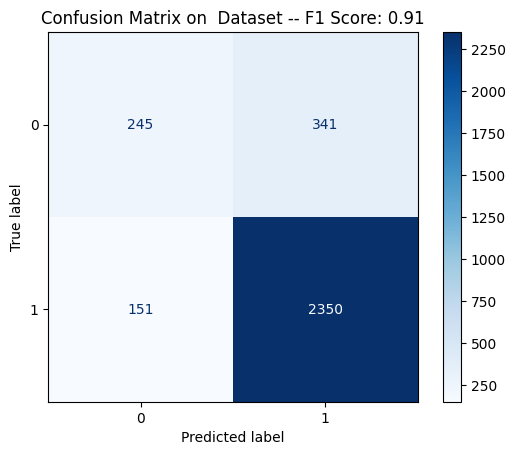

In [ ]:
displayConfusionMatrix(y_test["Quality"], model_quality_sgd.predict(X_test))

## 3.2 Model Serve

In [ ]:
model_serve_sgd = text_clf
model_serve_sgd.fit(X_train, y_train["Serve"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, min_df=4, ngram_range=(1, 5),
                                 stop_words=['a lô ', 'a ha ', 'ai ', 'ai ai ',
                                             'ai nấy ', 'ai đó ', 'alô ',
                                             'amen ', 'anh ', 'anh ấy ', 'ba ',
                                             'ba ba ', 'ba bản ', 'ba cùng ',
                                             'ba họ ', 'ba ngày ', 'ba ngôi ',
                                             'ba tăng ', 'bao giờ ', 'bao lâu ',
                                             'bao nhiêu ', 'bao nả ',
                                             'bay biến ', 'biết ', 'biết bao ',
                                             'biết bao nhiêu ', 'biết chắc ',
                                             'biết chừng nào ', 'biết mình ',
                                             'biết mấy ', ...],
                                 tokenizer=<function word_tokenize at 0x7df2bf9d3e20>)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
print(classification_report(y_test["Serve"], model_serve_sgd.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2442
           1       0.87      0.71      0.79       645

    accuracy                           0.92      3087
   macro avg       0.90      0.84      0.87      3087
weighted avg       0.92      0.92      0.92      3087



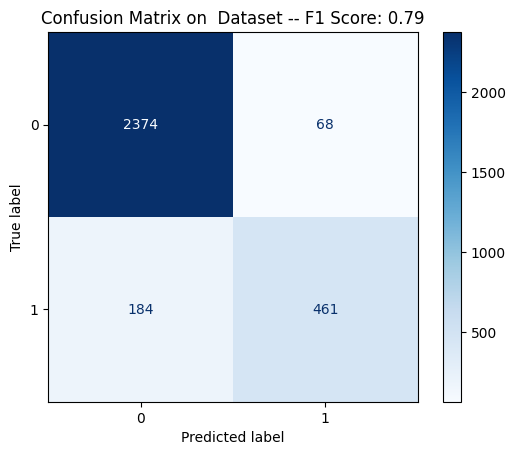

In [ ]:
displayConfusionMatrix(y_test["Serve"], model_serve_sgd.predict(X_test))

# 3.3 Model Pack

In [ ]:
model_pack_sgd = text_clf
model_pack_sgd.fit(X_train, y_train["Pack"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, min_df=4, ngram_range=(1, 5),
                                 stop_words=['a lô ', 'a ha ', 'ai ', 'ai ai ',
                                             'ai nấy ', 'ai đó ', 'alô ',
                                             'amen ', 'anh ', 'anh ấy ', 'ba ',
                                             'ba ba ', 'ba bản ', 'ba cùng ',
                                             'ba họ ', 'ba ngày ', 'ba ngôi ',
                                             'ba tăng ', 'bao giờ ', 'bao lâu ',
                                             'bao nhiêu ', 'bao nả ',
                                             'bay biến ', 'biết ', 'biết bao ',
                                             'biết bao nhiêu ', 'biết chắc ',
                                             'biết chừng nào ', 'biết mình ',
                                             'biết mấy ', ...],
                                 tokenizer=<function word_tokenize at 0x7df2bf9d3e20>)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
print(classification_report(y_test["Pack"], model_pack_sgd.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2476
           1       0.94      0.87      0.90       611

    accuracy                           0.96      3087
   macro avg       0.95      0.93      0.94      3087
weighted avg       0.96      0.96      0.96      3087



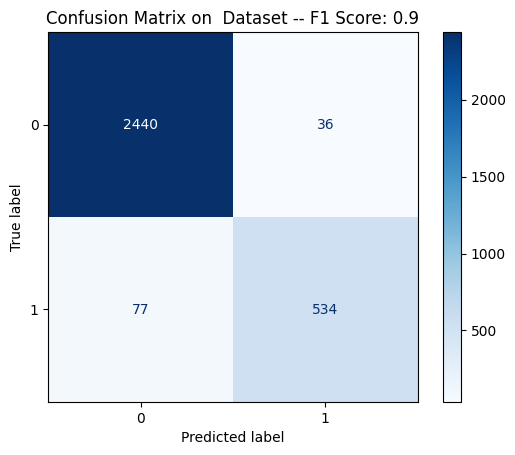

In [ ]:
displayConfusionMatrix(y_test["Pack"], model_pack_sgd.predict(X_test))

## 3.4 Model Shipping

In [ ]:
model_ship_sgd = text_clf
model_ship_sgd.fit(X_train, y_train["Shipping"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, min_df=4, ngram_range=(1, 5),
                                 stop_words=['a lô ', 'a ha ', 'ai ', 'ai ai ',
                                             'ai nấy ', 'ai đó ', 'alô ',
                                             'amen ', 'anh ', 'anh ấy ', 'ba ',
                                             'ba ba ', 'ba bản ', 'ba cùng ',
                                             'ba họ ', 'ba ngày ', 'ba ngôi ',
                                             'ba tăng ', 'bao giờ ', 'bao lâu ',
                                             'bao nhiêu ', 'bao nả ',
                                             'bay biến ', 'biết ', 'biết bao ',
                                             'biết bao nhiêu ', 'biết chắc ',
                                             'biết chừng nào ', 'biết mình ',
                                             'biết mấy ', ...],
                                 tokenizer=<function word_tokenize at 0x7df2bf9d3e20>)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
print(classification_report(y_test["Shipping"], model_ship_sgd.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1808
           1       0.89      0.87      0.88      1279

    accuracy                           0.90      3087
   macro avg       0.90      0.90      0.90      3087
weighted avg       0.90      0.90      0.90      3087



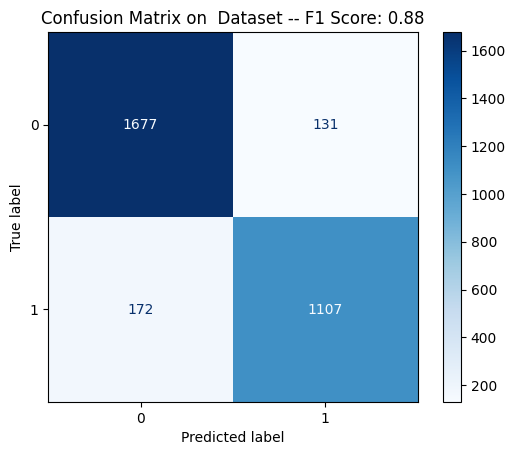

In [ ]:
displayConfusionMatrix(y_test["Shipping"], model_ship_sgd.predict(X_test))

# 3.5 MultiOutputClassifier

(This strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification).

In [ ]:
from sklearn.metrics import hamming_loss
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
model = SGDClassifier(loss='hinge', penalty='l2',
alpha=1e-3, random_state=42,
max_iter=5, tol=None)

vect = CountVectorizer(ngram_range=(1, 5), tokenizer=word_tokenize, stop_words=STOPWORDS,max_df=0.5, min_df=4)
X_train_v = vect.fit_transform(X_train)
X_test_v = vect.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'ai', 'alô', 'amen', 'anh', 'ba', 'ba ba', 'bao', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bay', 'biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết đâu', 'buổi', 'bà', 'bài', 'bác', 'bán', 'bán dạ', 'bây', 'bây bẩy', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bông', 'bước', 'bạn', 'bản', 'bản thân', 'bất', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất thình', 'bất tử', 'bất ý', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâu nay', 'bấy nay', 'bấy nhiêu', 'bập', 'bập bõm', 'bắt đầu', 'bằng', 'bển', 'bệt', 'bị', 

In [ ]:
clf = MultiOutputClassifier(model).fit(X_train_v, y_train)
prediction = clf.predict(X_test_v)

In [ ]:
label_cols = ["Quality", "Pack", "Serve", "Shipping"]
print("Classification report from MultiOutputClassifier model")
print('Hamming Loss: ', round(hamming_loss(y_test, prediction),2))
for i in range(len(label_cols)):
  print(f"classification report of {label_cols[i]}")
  print(classification_report(y_test[label_cols[i]], prediction[:, i]))

Classification report from MultiOutputClassifier model
Hamming Loss:  0.09
classification report of Quality
              precision    recall  f1-score   support

           0       0.62      0.42      0.50       586
           1       0.87      0.94      0.91      2501

    accuracy                           0.84      3087
   macro avg       0.75      0.68      0.70      3087
weighted avg       0.82      0.84      0.83      3087

classification report of Pack
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2476
           1       0.94      0.87      0.90       611

    accuracy                           0.96      3087
   macro avg       0.95      0.93      0.94      3087
weighted avg       0.96      0.96      0.96      3087

classification report of Serve
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2442
           1       0.87      0.71      0.79       645

    accuracy 

# 3.5 Classifier Chain
Each model makes a prediction in the order specified by the chain using all of the available features provided to the model plus the predictions of models that are earlier in the chain.

In [ ]:
from sklearn.multioutput import ClassifierChain

clf = ClassifierChain(model).fit(X_train_v, y_train)
prediction = clf.predict(X_test_v)


In [ ]:
label_cols = ["Quality", "Pack", "Serve", "Shipping"]
print("Classification report from Classifier Chain model")
print('Hamming Loss: ', round(hamming_loss(y_test, prediction),2))
for i in range(len(label_cols)):
  print(f"classification report of {label_cols[i]}")
  print(classification_report(y_test[label_cols[i]], prediction[:, i]))

Classification report from Classifier Chain model
Hamming Loss:  0.09
classification report of Quality
              precision    recall  f1-score   support

           0       0.62      0.42      0.50       586
           1       0.87      0.94      0.91      2501

    accuracy                           0.84      3087
   macro avg       0.75      0.68      0.70      3087
weighted avg       0.82      0.84      0.83      3087

classification report of Pack
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2476
           1       0.94      0.88      0.91       611

    accuracy                           0.96      3087
   macro avg       0.95      0.93      0.94      3087
weighted avg       0.96      0.96      0.96      3087

classification report of Serve
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2442
           1       0.85      0.73      0.78       645

    accuracy      